# Time_Series_Prediction : Corporation Favorita Grocery

## Loading Libraries

In [95]:
# For loading data and related works
import numpy as np
import pandas as pd

# For controlling warnings
import warnings

# For data visualizatioon
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# For connecting to the database
import pyodbc

# For stating hypothesis
import scipy.stats as stats

# For feature encoding
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# For data balancing
from imblearn.over_sampling import SMOTE

# For data spliting
from sklearn.model_selection import train_test_split

# For operating system
import os
import pickle

warnings.filterwarnings('ignore')

# Loading data from database

In [96]:
pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [97]:
from dotenv import load_dotenv, dotenv_values

In [98]:
#%%writefile .gitignore

In [99]:
env_var = dotenv_values(".env")

In [100]:
load_dotenv()

True

In [101]:
server = env_var.get("SERVER")
database = env_var.get("DATABASE")
username = env_var.get("USERNAME_")
password = env_var.get("PASSWORD")

In [102]:
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [103]:
connection = pyodbc.connect(connection_string)

## Loading oil table

In [104]:
query = "Select * from dbo.oil"
data_oil = pd.read_sql(query, connection, parse_dates=["date"])

In [105]:
data_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [106]:
data_oil.to_csv("data_oil")

## Loading holidy_event table

In [107]:
query = "Select * from dbo.holidays_events"
data_holiday_event = pd.read_sql(query, connection , parse_dates=["date"])

In [108]:
data_holiday_event.tail()

,date,type,locale,locale_name,description,transferred
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [109]:
data_holiday_event.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [110]:
data_holiday_event.rename(columns = {"type" :"holiday_type" } , inplace = True)

In [111]:
data_holiday_event.head()

,date,holiday_type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [112]:
data_holiday_event.to_csv("data_holiday_event")

## Loading store table

In [113]:
query = "Select * from dbo.stores"
data_store = pd.read_sql(query, connection)

In [114]:
data_store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [115]:
data_store.to_csv("data_store")

## Loading train table

In [116]:
data_train = pd.read_csv("store-sales-forecasting/train.csv" , parse_dates=["date"])

In [117]:
data_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [118]:
data_train.to_csv("data_train")

In [119]:
data_transaction = pd.read_csv("store-sales-forecasting/transactions.csv" , parse_dates=["date"])

In [120]:
data_transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [121]:
data_transaction.to_csv("data_transaction")

## Loading test data from one drive

In [122]:
data_test = pd.read_csv("test.csv" , parse_dates=["date"])

In [123]:
data_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


# Merging data

In [124]:
oil_list = list(data_oil.columns)
holiday_event_list = list(data_holiday_event.columns)
store_list = list(data_store.columns)
train_list = list(data_train.columns)

In [125]:
print(oil_list)
print(holiday_event_list)
print(store_list)
print(train_list)

['date', 'dcoilwtico']
['date', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred']
['store_nbr', 'city', 'state', 'type', 'cluster']
['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']


## We can see that there are relations between our datasets. so using their relational columns to merge them

In [126]:
data_oil_and_holiday_event = pd.merge(data_holiday_event , data_oil , on = "date" )
data_oil_and_holiday_event = data_oil_and_holiday_event[data_oil_and_holiday_event["date"].notnull()]
data_oil_and_holiday_event.head()

,date,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False,NaN
1,2013-02-11,Holiday,National,Ecuador,Carnaval,False,97.010002
2,2013-02-12,Holiday,National,Ecuador,Carnaval,False,97.480003
3,2013-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,97.099998
4,2013-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,91.230003


In [127]:
print(store_list)
print(train_list)

['store_nbr', 'city', 'state', 'type', 'cluster']
['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']


In [128]:
data_store_and_train = pd.merge(data_store , data_train , on = "store_nbr" )
data_store_and_train = data_store_and_train[data_store_and_train["store_nbr"].notnull()]
data_store_and_train.head()

,store_nbr,city,state,type,cluster,id,date,family,sales,onpromotion
0,1,Quito,Pichincha,D,13,0,2013-01-01,AUTOMOTIVE,0.0,0
1,1,Quito,Pichincha,D,13,1,2013-01-01,BABY CARE,0.0,0
2,1,Quito,Pichincha,D,13,2,2013-01-01,BEAUTY,0.0,0
3,1,Quito,Pichincha,D,13,3,2013-01-01,BEVERAGES,0.0,0
4,1,Quito,Pichincha,D,13,4,2013-01-01,BOOKS,0.0,0


In [129]:
store_and_train_list = list(data_store_and_train.columns)
oil_and_holiday_event_list = list(data_oil_and_holiday_event.columns)

In [130]:
print(store_and_train_list)
print(oil_and_holiday_event_list)

['store_nbr', 'city', 'state', 'type', 'cluster', 'id', 'date', 'family', 'sales', 'onpromotion']
['date', 'holiday_type', 'locale', 'locale_name', 'description', 'transferred', 'dcoilwtico']


In [131]:
data_store_and_train.shape , data_oil_and_holiday_event.shape

((3000888, 10), (202, 7))

In [132]:
data_final = pd.merge(data_store_and_train , data_oil_and_holiday_event , on = "date" )
data_final = data_final[data_final["date"].notnull()]
data_final.head()

,store_nbr,city,state,type,cluster,id,date,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,1,Quito,Pichincha,D,13,0,2013-01-01,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
1,1,Quito,Pichincha,D,13,1,2013-01-01,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2,1,Quito,Pichincha,D,13,2,2013-01-01,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
3,1,Quito,Pichincha,D,13,3,2013-01-01,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
4,1,Quito,Pichincha,D,13,4,2013-01-01,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN


In [133]:
data_final = data_final.set_index("date")

In [134]:
data_final.tail()

,store_nbr,city,state,type,cluster,id,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico
date,,,,,,,,,,,,,,,
2017-08-15,54,El Carmen,Manabi,C,3,3000751,POULTRY,59.619,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57
2017-08-15,54,El Carmen,Manabi,C,3,3000752,PREPARED FOODS,94.000,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57
2017-08-15,54,El Carmen,Manabi,C,3,3000753,PRODUCE,915.371,76,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57
2017-08-15,54,El Carmen,Manabi,C,3,3000754,SCHOOL AND OFFICE SUPPLIES,0.000,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57
2017-08-15,54,El Carmen,Manabi,C,3,3000755,SEAFOOD,3.000,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57


### Finally data's used for training are meged into one dataset

## Stating Hypothesis

Null Hypothesiss : There is no significant relation between daily price and amount of sale

Alternative Hypothesis : There is a significant relation between daily price and amount of sale

In [135]:
data_final.shape

(352836, 15)

In [136]:
sample_data = data_final.sample(n=None, frac=0.5, replace=False, weights=None, random_state=2, axis=0)


In [137]:
sample1 = sample_data["store_nbr"]
sample2 = sample_data["sales"]

In [138]:
sample1 = sample1.dropna()
sample2 = sample2.dropna()

In [139]:
sample1.shape , sample2.shape

((176418,), (176418,))

In [140]:
# Import libraries
from scipy import stats
import numpy as np

# Perform a t-test
t_stat, p_value = stats.ttest_ind(sample1, sample2)

# Print the results
print("t-statistic:", t_stat)
print("p-value:", p_value)


t-statistic: -123.86023257210132
p-value: 0.0


In [141]:
alpha = 0.05
if p_value > alpha:
    print("accept the null hypothesis")
else:
    print("reject null hypothesis ")

reject null hypothesis 


### Null hypothesis is rejected. This means there is a relation between daily price oil and sales amount

# Handling missing data

In [142]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352836 entries, 2013-01-01 to 2017-08-15
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store_nbr     352836 non-null  int64  
 1   city          352836 non-null  object 
 2   state         352836 non-null  object 
 3   type          352836 non-null  object 
 4   cluster       352836 non-null  int64  
 5   id            352836 non-null  int64  
 6   family        352836 non-null  object 
 7   sales         352836 non-null  float64
 8   onpromotion   352836 non-null  int64  
 9   holiday_type  352836 non-null  object 
 10  locale        352836 non-null  object 
 11  locale_name   352836 non-null  object 
 12  description   352836 non-null  object 
 13  transferred   352836 non-null  bool   
 14  dcoilwtico    322542 non-null  float64
dtypes: bool(1), float64(2), int64(4), object(8)
memory usage: 40.7+ MB


In [143]:
# checking for NaN in dataframe dcoilwtico column
data_final.query("dcoilwtico != dcoilwtico").head()

,store_nbr,city,state,type,cluster,id,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico
date,,,,,,,,,,,,,,,
2013-01-01,1,Quito,Pichincha,D,13,0,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2013-01-01,1,Quito,Pichincha,D,13,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2013-01-01,1,Quito,Pichincha,D,13,2,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2013-01-01,1,Quito,Pichincha,D,13,3,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2013-01-01,1,Quito,Pichincha,D,13,4,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN


In [144]:
data_final.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster', 'id', 'family',
       'sales', 'onpromotion', 'holiday_type', 'locale', 'locale_name',
       'description', 'transferred', 'dcoilwtico'],
      dtype='object')

In [145]:
data_final["year"] = data_final.index.year
data_final["month"] = data_final.index.month
data_final["weekday name"] = data_final.index.day_name()

In [170]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352836 entries, 2013-01-01 to 2017-08-15
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store_nbr     352836 non-null  int64  
 1   city          352836 non-null  object 
 2   state         352836 non-null  object 
 3   type          352836 non-null  object 
 4   cluster       352836 non-null  int64  
 5   id            352836 non-null  int64  
 6   family        352836 non-null  object 
 7   sales         352836 non-null  float64
 8   onpromotion   352836 non-null  int64  
 9   holiday_type  352836 non-null  object 
 10  locale        352836 non-null  object 
 11  locale_name   352836 non-null  object 
 12  description   352836 non-null  object 
 13  transferred   352836 non-null  bool   
 14  dcoilwtico    352836 non-null  float64
 15  year          352836 non-null  int64  
 16  month         352836 non-null  int64  
 17  weekday name  352836 non-null  o

### Daily oil price  has null values

<AxesSubplot:xlabel='date'>

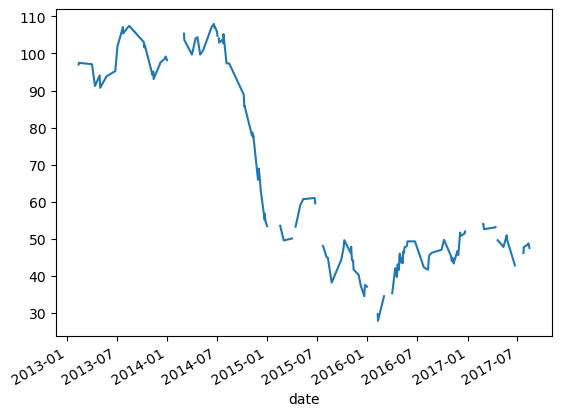

In [149]:
data_final.dcoilwtico.plot()

## Imputation for missing records with a strategy of mean

The reason for using mean as a strategy is depends on the outliers. The data feature has no outlier as figure below. so it is possible to us mean. But if there was outlier to the data it will be good practice to use median. Because the mean will be dominated by outlier. 

For our scenario mean is the strategy.

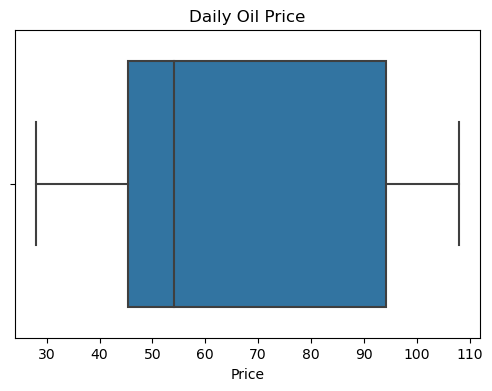

In [171]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='dcoilwtico', data=data_final)
plt.title('Daily Oil Price')
plt.xlabel('Price')
plt.show()

In [178]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "mean")
imputer.fit(data_final.dcoilwtico.array.reshape(-1,1))

SimpleImputer()

In [179]:
data_final.dcoilwtico = imputer.fit_transform(data_final.dcoilwtico.array.reshape(-1,1))

In [180]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352836 entries, 2013-01-01 to 2017-08-15
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store_nbr     352836 non-null  int64  
 1   city          352836 non-null  object 
 2   state         352836 non-null  object 
 3   type          352836 non-null  object 
 4   cluster       352836 non-null  int64  
 5   id            352836 non-null  int64  
 6   family        352836 non-null  object 
 7   sales         352836 non-null  float64
 8   onpromotion   352836 non-null  int64  
 9   holiday_type  352836 non-null  object 
 10  locale        352836 non-null  object 
 11  locale_name   352836 non-null  object 
 12  description   352836 non-null  object 
 13  transferred   352836 non-null  bool   
 14  dcoilwtico    352836 non-null  float64
 15  year          352836 non-null  int64  
 16  month         352836 non-null  int64  
 17  weekday name  352836 non-null  o

### Now lets check the featue after imputation

<AxesSubplot:xlabel='date'>

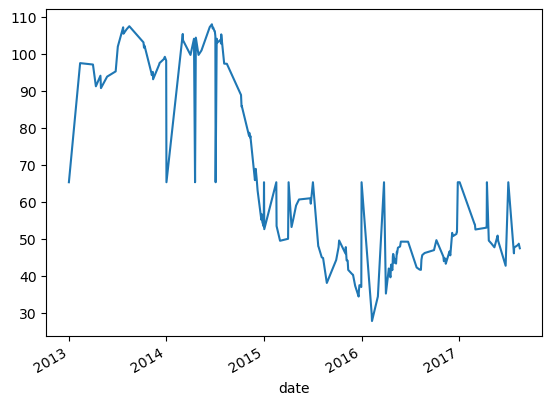

In [181]:
data_final.dcoilwtico.plot()

# Questions

## 1. Which cities have a high number of promotion

In [216]:
promotion_city = data_final.groupby("city").count()["onpromotion"].sort_values(ascending=False).head(5)
promotion_city = pd.DataFrame({'year':promotion_city.index, 'amount':promotion_city.values})

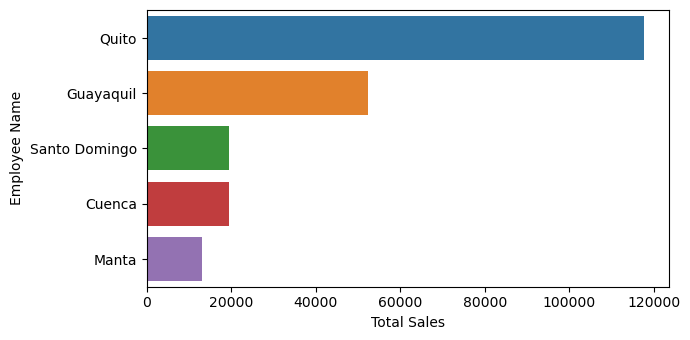

In [291]:
#create horizontal barplot
sns.barplot(x=promotion_city.amount , y=promotion_city.year, orient='h' )

#add plot title
sns.title = 'Total Sales by Employee'

#add axis labels
plt.xlabel('Total Sales')
plt.ylabel('Employee Name')
plt.show()

A city named as "Quito" has more than 10 thousand promotions over the past five years. "Guayaquil" also takes a promotion in the city around 5 thousand.

## 2. Which year has a high number of promotion

In [194]:
promotion_year = data_final.groupby("year").count()["onpromotion"].sort_values(ascending=False).head(5)

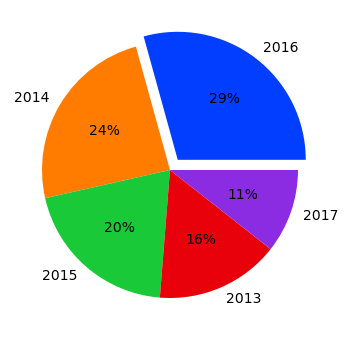

<Figure size 1000x700 with 0 Axes>

In [297]:
#define data
data = promotion_year
labels = ['2016', '2014', '2015', "2013" , "2017" ]

#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:5]

# declaring exploding pie
explode = [0.1, 0, 0, 0, 0]

#create pie chart
plt.pie(data, labels = labels, explode = explode , colors = colors, autopct='%.0f%%' )
plt.figure(figsize=(10, 7))

plt.show()


# 3. Which cities have a high amount of sale transactions

In [300]:
sale_city = data_final.groupby("city").count()["sales"].sort_values(ascending=False).head(5)
sale_city

city
Quito            117612
Guayaquil         52272
Santo Domingo     19602
Cuenca            19602
Manta             13068
Name: sales, dtype: int64

In [ ]:
#create horizontal barplot
sns.barplot(x=promotion_city.amount , y=promotion_city.year, orient='h' )

#add plot title
sns.title = 'Total Sales by Employee'

#add axis labels
plt.xlabel('Total Sales')
plt.ylabel('Employee Name')
plt.show()

# 3. Show how is the daily price of oil momement over the year

<AxesSubplot:title={'center':'Daily Price over the year'}, xlabel='year'>

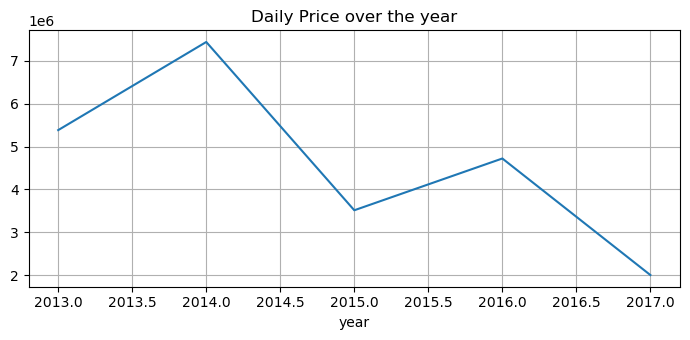

In [273]:
data_final.groupby("year").sum()["dcoilwtico"].plot(grid=True , title = "Daily Price over the year" )


The graph show a seasonality change on price of oil. The first year can affect the next one by giving an inverse result. For example when we look at 2013 the price is increasing, then the next year,2014, is decreasing. The same thing percieved in 2015 which increase the price because of the last year was decresing. It has up and down flow over the years.

# 4. Show the relation between daily oil price and amount of sales 

In [324]:
price_year = data_final.groupby("year").sum()["dcoilwtico"]
price_year = pd.DataFrame({'year':price_year.index, 'sale_amount':price_year.values})
price_year

,year,sale_amount
0,2013,5.385328e+06
1,2014,7.443127e+06
2,2015,3.513512e+06
3,2016,4.722547e+06
4,2017,2.000220e+06


In [322]:
oil_year = data_final.groupby("year").sum()["sales"]
oil_year = pd.DataFrame({'year':oil_year.index, 'oil_price':oil_year.values})
oil_year

,year,oil_price
0,2013,1.166394e+07
1,2014,2.809424e+07
2,2015,2.752824e+07
3,2016,4.568113e+07
4,2017,1.792345e+07


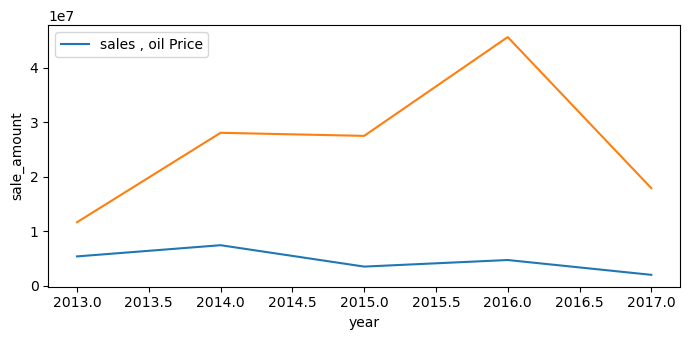

In [341]:
sns.lineplot(x = "year", y = "sale_amount", data=price_year)
sns.lineplot(x = "year", y = "oil_price", data=oil_year )
plt.legend(labels = ["sales , oil Price" ] )

plt.show()

In [250]:
data_final.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster', 'id', 'family',
       'sales', 'onpromotion', 'holiday_type', 'locale', 'locale_name',
       'description', 'transferred', 'dcoilwtico', 'year', 'month',
       'weekday name'],
      dtype='object')

# Exploratory Data Analysis

In [191]:
data_final.tail()

,store_nbr,city,state,type,cluster,id,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,weekday name
date,,,,,,,,,,,,,,,,,,
2017-08-15,54,El Carmen,Manabi,C,3,3000751,POULTRY,59.619,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,2017,8,Tuesday
2017-08-15,54,El Carmen,Manabi,C,3,3000752,PREPARED FOODS,94.000,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,2017,8,Tuesday
2017-08-15,54,El Carmen,Manabi,C,3,3000753,PRODUCE,915.371,76,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,2017,8,Tuesday
2017-08-15,54,El Carmen,Manabi,C,3,3000754,SCHOOL AND OFFICE SUPPLIES,0.000,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,2017,8,Tuesday
2017-08-15,54,El Carmen,Manabi,C,3,3000755,SEAFOOD,3.000,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.57,2017,8,Tuesday


<AxesSubplot:title={'center':'Oil Prices'}, xlabel='date', ylabel='Oil Price'>

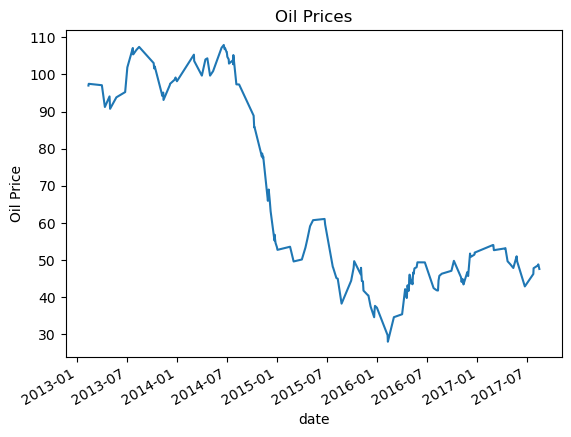

In [407]:
# visualizing data

data_final.dcoilwtico.plot(ylabel = "Oil Price" , title = "Oil Prices")

## The graph shows there is a irregular variation trend and stationary. From 2013 to end of 2014 the oil price is on a stationary mode. The downward change is percieved on 2015 which has 50 difference. For the rest years means from 2015 to 2017 the trend is decrease at a minimum state. 

In [408]:
data_final.columns


Index(['store_nbr', 'city', 'state', 'type', 'cluster', 'id', 'family',
       'sales', 'onpromotion', 'holiday_type', 'locale', 'locale_name',
       'description', 'transferred', 'dcoilwtico', 'year', 'month',
       'weekday name'],
      dtype='object')

<AxesSubplot:title={'center':'Amount of sales per store number'}, xlabel='store_nbr', ylabel='Amount of Sale'>

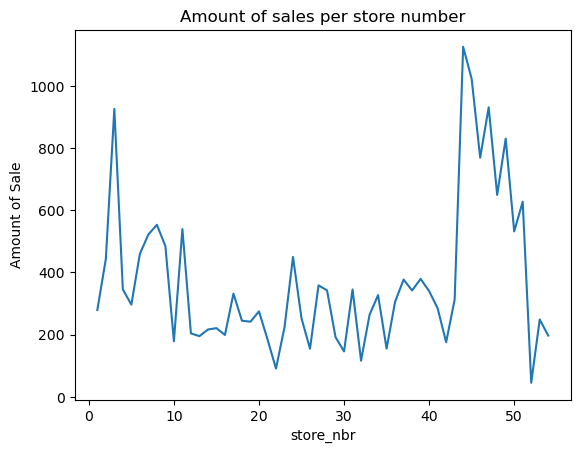

In [409]:

plt.show()
data_final.groupby("store_nbr")["sales"].mean().plot(ylabel="Amount of Sale" , title = "Amount of sales per store number")

## A sale of stores are different from one to another. There is an increasing amount os saling in store 0 to 5. Also stores labled from 40 to 50 has a seasonal variation.

<AxesSubplot:title={'center':'Sales per Year'}, xlabel='year', ylabel='Amount of Sale'>

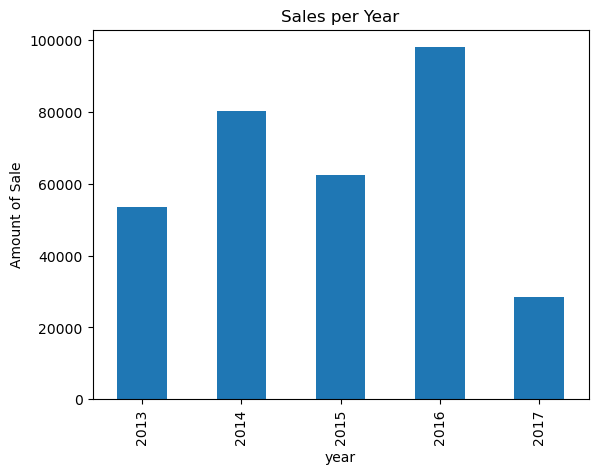

In [410]:
plt.ylabel = "Sales Amount"
data_final.groupby("year").count()["sales"].plot(ylabel="Amount of Sale"   , kind = "bar",  title = "Sales per Year" )

## Year 2016 has the largest sale from our records. 2017 , in other side, make a round 30 thousand sales. The rest years are ranges from 50 to 80 thound of sales.

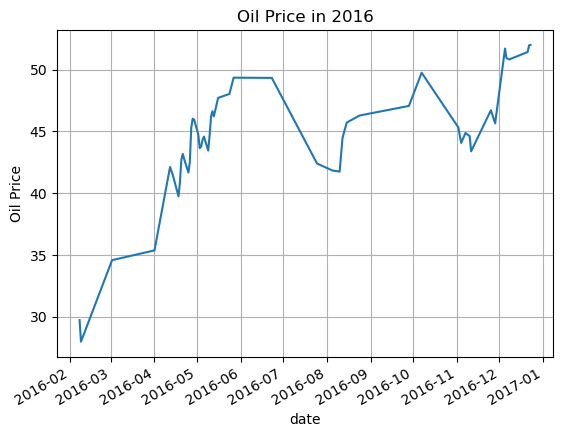

In [448]:

data_final[data_final["year"] == 2016].dcoilwtico.plot(ylabel ="Oil Price" , title = "Oil Price in 2016")
plt.grid()


## For the first five month there is an upward trend. From senventh month to the end of year the plot has irregular variation

## This graph tell us unexpected result. It is not usual for market as the price of oil increase also the year become the top record on sale. 

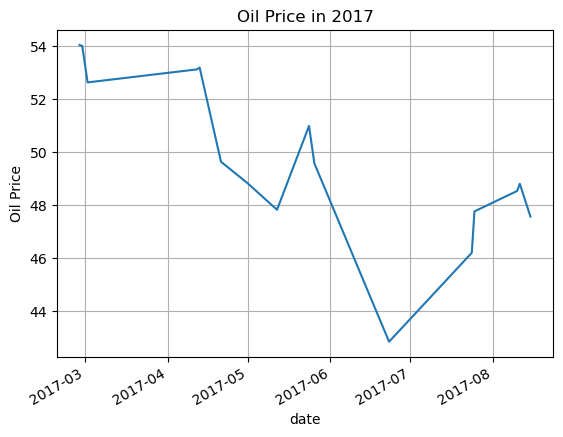

In [449]:
data_final[data_final["year"] == 2017].dcoilwtico.plot(ylabel ="Oil Price" , title = "Oil Price in 2017")
plt.grid()

## There is irregular variation standing from the graph, price of oil is downgrading as the month increases. and from both 2016 and 2017 data, the is an inverse relation between month increasng and price of oil decresing.

In [413]:
data_final.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster', 'id', 'family',
       'sales', 'onpromotion', 'holiday_type', 'locale', 'locale_name',
       'description', 'transferred', 'dcoilwtico', 'year', 'month',
       'weekday name'],
      dtype='object')

In [414]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 322542 entries, 2013-02-11 to 2017-08-15
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store_nbr     322542 non-null  int64  
 1   city          322542 non-null  object 
 2   state         322542 non-null  object 
 3   type          322542 non-null  object 
 4   cluster       322542 non-null  int64  
 5   id            322542 non-null  int64  
 6   family        322542 non-null  object 
 7   sales         322542 non-null  float64
 8   onpromotion   322542 non-null  int64  
 9   holiday_type  322542 non-null  object 
 10  locale        322542 non-null  object 
 11  locale_name   322542 non-null  object 
 12  description   322542 non-null  object 
 13  transferred   322542 non-null  bool   
 14  dcoilwtico    322542 non-null  float64
 15  year          322542 non-null  int64  
 16  month         322542 non-null  int64  
 17  weekday name  322542 non-null  o

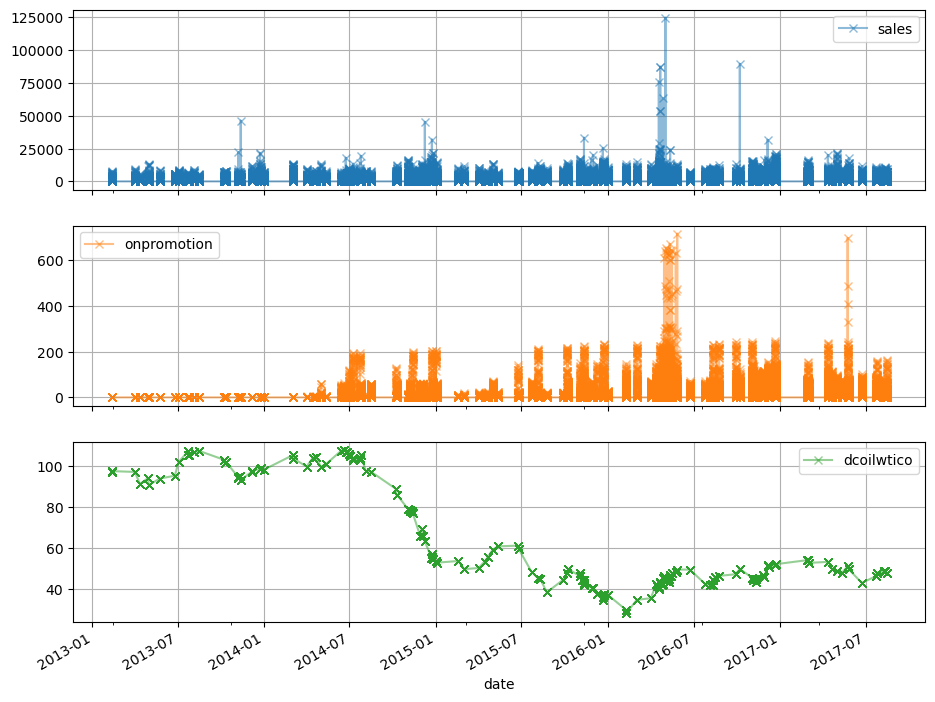

In [456]:
cols_plot = ["sales" , "onpromotion" , "dcoilwtico"]
axes = data_final[cols_plot].plot(marker = "x" , alpha = 0.5 , figsize = (11 , 9) ,subplots = True , grid=True)


## A plot can inform us promotion is not high as the oil price is too much. Briefly can conclude that for high number of promotion there must be cheap amount oil.

In [416]:
pd.date_range("2016-01-01" , "2016-01-30" , freq="d")

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
               '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
               '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
               '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
               '2016-01-29', '2016-01-30'],
              dtype='datetime64[ns]', freq='D')

In [417]:
data_cols = ["sales" , "onpromotion" , "dcoilwtico"]
data_weekly_mean = data_final[data_cols].resample("W").mean()
data_weekly_mean.head()

,sales,onpromotion,dcoilwtico
date,,,
2013-02-17,164.822778,0.0,97.245003
2013-02-24,NaN,NaN,NaN
2013-03-03,NaN,NaN,NaN
2013-03-10,NaN,NaN,NaN
2013-03-17,NaN,NaN,NaN


<AxesSubplot:title={'center':'Number of stores in cities'}, xlabel='city', ylabel='numer of stores'>

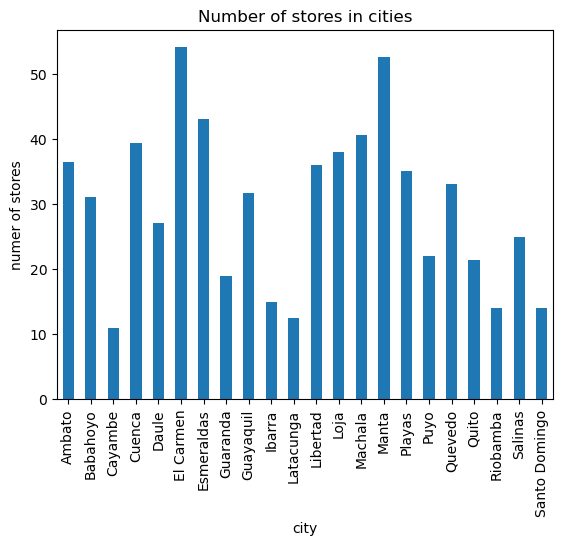

In [446]:
data_final.groupby("city").mean()["store_nbr"].plot(kind = "bar" , title = "Number of stores in cities" , ylabel = "numer of stores")

In [457]:
data_final.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster', 'id', 'family',
       'sales', 'onpromotion', 'holiday_type', 'locale', 'locale_name',
       'description', 'transferred', 'dcoilwtico', 'year', 'month',
       'weekday name', 'store_per_city'],
      dtype='object')

## How many promotion are done on each year

<AxesSubplot:ylabel='year'>

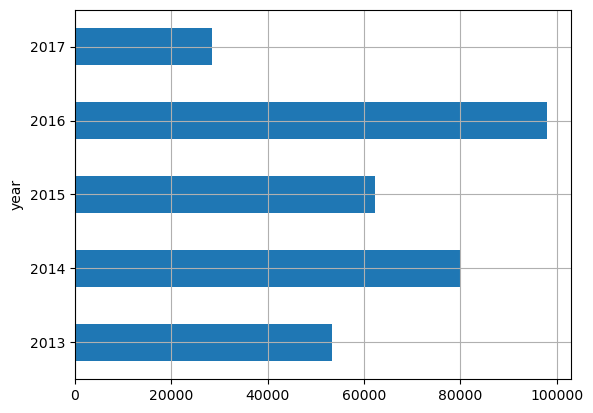

In [495]:
data_final.groupby("year").count()["onpromotion"].plot(kind = "barh", grid = True)

2016 and 2014 are the top promotion years.

# How many promotion is done in 2016

In [499]:
data_final.loc["2016"]

,store_nbr,city,state,type,cluster,id,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,weekday name,store_per_city
date,,,,,,,,,,,,,,,,,,,
2016-02-08,1,Quito,Pichincha,D,13,2013660,AUTOMOTIVE,0.000,0,Holiday,National,Ecuador,Carnaval,False,29.709999,2016,2,Monday,NaN
2016-02-08,1,Quito,Pichincha,D,13,2013661,BABY CARE,0.000,0,Holiday,National,Ecuador,Carnaval,False,29.709999,2016,2,Monday,NaN
2016-02-08,1,Quito,Pichincha,D,13,2013662,BEAUTY,4.000,0,Holiday,National,Ecuador,Carnaval,False,29.709999,2016,2,Monday,NaN
2016-02-08,1,Quito,Pichincha,D,13,2013663,BEVERAGES,531.000,17,Holiday,National,Ecuador,Carnaval,False,29.709999,2016,2,Monday,NaN
2016-02-08,1,Quito,Pichincha,D,13,2013664,BOOKS,0.000,0,Holiday,National,Ecuador,Carnaval,False,29.709999,2016,2,Monday,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,54,El Carmen,Manabi,C,3,2583763,POULTRY,229.418,7,Additional,National,Ecuador,Navidad-2,False,52.009998,2016,12,Friday,NaN
2016-12-23,54,El Carmen,Manabi,C,3,2583764,PREPARED FOODS,64.000,0,Additional,National,Ecuador,Navidad-2,False,52.009998,2016,12,Friday,NaN
2016-12-23,54,El Carmen,Manabi,C,3,2583765,PRODUCE,904.609,2,Additional,National,Ecuador,Navidad-2,False,52.009998,2016,12,Friday,NaN


## What are the most usable family products

<AxesSubplot:xlabel='family'>

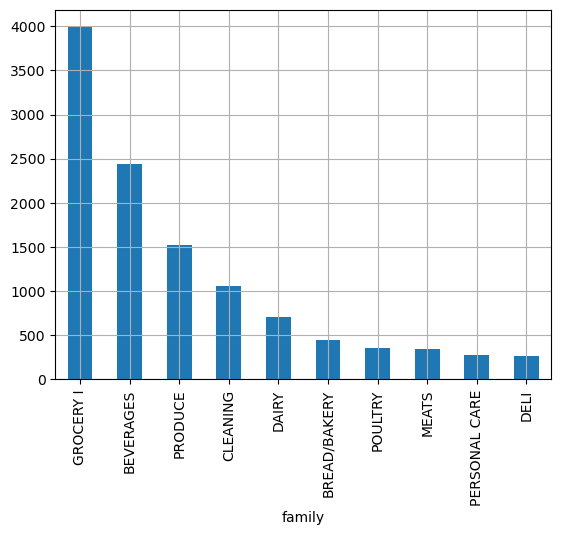

In [483]:
data_final.groupby("family").mean()["sales"].sort_values(ascending = False)[:10].plot(kind = "bar" , grid = True)

## Grocery I and Beverages are the most usable products

# Feature Engineering

In [420]:
data_final.columns

Index(['store_nbr', 'city', 'state', 'type', 'cluster', 'id', 'family',
       'sales', 'onpromotion', 'holiday_type', 'locale', 'locale_name',
       'description', 'transferred', 'dcoilwtico', 'year', 'month',
       'weekday name'],
      dtype='object')

In [427]:
data_final.city.value_counts().sum()

322542

In [429]:

data_final["store_per_city"] = data_final.store_nbr.value_counts() / data_final.city.value_counts()